In [4]:
import numpy as np
import cv2
import os

from scipy import ndimage
from scipy.io import savemat
import matplotlib.pyplot as plt

In [5]:
roi2 = [672,672+1244, 96, 96+1456]
roi = [x//2 for x in roi2]
R = 1024
C = 1224
R_roi = roi[1] - roi[0] 
C_roi = roi[3] - roi[2] 
vmin=520
vmax=1400
gamma = 1.5
cmap='nipy_spectral'
res_path = './results'
dat_path = './experiments/test_2023_03_14_18_48/calibration0'

binning = 2

#  D/fine the size of the image
PROJ_WIDTH = 1280 // binning
PROJ_HEIGHT = 720 // binning

cam_H, cam_W = 1536//binning, 2048//binning
sensor_width_cam = 5.32 * 1e-3
cam_pitch = sensor_width_cam / cam_H
focal_length_cam = 8 * 1e-3

# Structured light

In [6]:
def read_epi_gc(dat_path, prefix):
    N_gc = 40 # number of graycode images
    fsize = 3

    # load captured patterns
    cap_roi = []
    for i in range(N_gc):
        fn = os.path.join(dat_path, '%s_%04d.png'%(prefix, i))
        im_roi = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)
        im_roi = ndimage.median_filter(im_roi, size=fsize)
        cap_roi.append(im_roi)
        
    return cap_roi

def estimate_depth_graycode(roi, cap_roi):
    # parameters
    cam_shape = (cam_H, cam_W) # row, column
    proj_shape = (PROJ_HEIGHT, PROJ_WIDTH) # row, column
    N_gc = 40 # number of graycode images
    N_tot = N_gc  # number of capture images (graycode + white + black)
    gc_step = 1 # should be 1 
    black_thr = 0
    white_thr = 0
    
    # captured patterns
    cap = []
    # dmap_SL = estimate_depth_graycode(roi2, im)

    for cap_roi_i in cap_roi:
        im = np.zeros(cam_shape).astype(np.uint8)
        # print(im.shape)
        # print(cap_roi_i)
        # print(cap_roi)
        im[roi[0]:roi[1], roi[2]:roi[3]] = cap_roi_i
        cap.append(im)
    
    # prepare simulation patterns
    gc_height = int((proj_shape[0]-1)/gc_step)+1
    gc_width = int((proj_shape[1]-1)/gc_step)+1
    graycode = cv2.structured_light_GrayCodePattern.create(gc_width, gc_height)
    graycode.setBlackThreshold(black_thr)
    graycode.setWhiteThreshold(white_thr)
    sim = graycode.generate()[1]
    sim_w = np.ones(proj_shape)
    sim_b = np.zeros(proj_shape)
    
    R,C = im.shape
    cap_w = cap[-2]
    cap_b = cap[-1]
    
    # estimate the correspondence map
    corr = np.zeros((cam_shape[0], cam_shape[1], 2))
    cam_pts = []
    prj_pts = []
    valid_mask = np.zeros(cam_shape)
    for r in range(cam_shape[0]):
        if r%100 == 0:
            print('decoding %.2f'%(r/cam_shape[0]))
        for c in range(cam_shape[1]):
            err, proj_pix = graycode.getProjPixel(cap, c, r)
            if not err:
                corr[r,c] = np.array(proj_pix)
                cam_pts.append((c,r))
                prj_pts.append((proj_pix[0],proj_pix[1]))
                valid_mask[r,c] = True
    
    # load the geometric calibration data
    camproj_calib_path = './calibration_propcam.xml'
    fs = cv2.FileStorage(camproj_calib_path, cv2.FileStorage_READ)
    img_shape = fs.getNode("img_shape").mat()
    cam_int = fs.getNode("cam_int").mat()
    cam_dist = fs.getNode("cam_dist").mat()
    proj_int = fs.getNode("proj_int").mat()
    proj_dist = fs.getNode("proj_dist").mat()
    cam_proj_rmat = fs.getNode("rotation").mat()
    cam_proj_tvec = fs.getNode("translation").mat()
    F = fs.getNode("fundamental").mat()
    E = fs.getNode("epipolar").mat()
    
    # undistort points using calibration
    cam_pts = np.array(cam_pts, dtype=np.float32) 
    cam_pts = cam_pts.reshape((-1, 1, 2))
    cam_pts_n = cv2.undistortPoints(cam_pts, cam_int, cam_dist, P=cam_int)
    prj_pts = np.array(prj_pts, dtype=np.float32) 
    prj_pts = prj_pts.reshape((-1, 1, 2))
    prj_pts_n = cv2.undistortPoints(prj_pts, proj_int, proj_dist, P=proj_int)
    
    # triangulate
    P0 = np.dot(cam_int, np.array([[1,0,0,0],
                                   [0,1,0,0],
                                   [0,0,1,0]]))
    P1 = np.concatenate((np.dot(proj_int, cam_proj_rmat), np.dot(proj_int,cam_proj_tvec)), axis = 1)
    triang_res = cv2.triangulatePoints(P0, P1, cam_pts_n, prj_pts_n)
    # cam coord point 3d
    points_3d = cv2.convertPointsFromHomogeneous(triang_res.T).squeeze()
    
    # xyz 
    cam_pts = cam_pts.astype(np.int16)
    xyz = np.zeros((R,C,3))
    xyz[cam_pts[:,0,1], cam_pts[:,0,0], 0]=points_3d[:,0]
    xyz[cam_pts[:,0,1], cam_pts[:,0,0], 1]=points_3d[:,1]
    xyz[cam_pts[:,0,1], cam_pts[:,0,0], 2]=points_3d[:,2]
    xyz = xyz[roi[0]:roi[1], roi[2]:roi[3],:]
    
    return xyz

In [7]:
im = read_epi_gc(dat_path, 'rgb_pattern')
# im = read_epi_gc('/projects/FHEIDE/polar/captured_data_cam_prj/20210114_lion_bust', 'graycode0000')

In [8]:
# print(im[0].shape,roi2)

In [9]:
cam_W

1024

In [10]:
# dmap_SL = estimate_depth_graycode(roi2, im)
dmap_SL = estimate_depth_graycode([0,cam_H,0,cam_W], im)

AttributeError: module 'cv2' has no attribute 'structured_light_GrayCodePattern'

In [ ]:
dmap_SL = cv2.resize(dmap_SL, (C_roi,R_roi))

In [ ]:
dmap_SL.shape

(622, 728, 3)

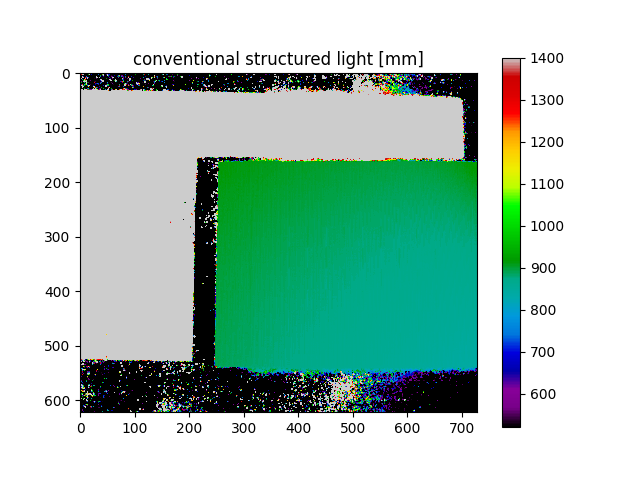

In [ ]:
plt.imshow(dmap_SL[...,2],vmin=vmin,vmax=vmax, cmap=cmap)
plt.title('conventional structured light [mm]')
plt.colorbar()
plt.savefig(os.path.join(res_path,'dmap_SL.svg'))
plt.show()

savemat('dmap_SL.mat', {'dmap_SL':dmap_SL})

# nmap_SL = surface_normal_xyz(dmap_SL, kfilt=5, dsize=11)
# plt.imshow((nmap_SL+1)/2)
# plt.title('conventional structured light XYZ normals')
# plt.savefig(os.path.join(res_path,'nmap_SL.svg'))
# plt.show()

# savemat('nmap_SL.mat', {'nmap_SL':nmap_SL})

In [ ]:
dmap_SL = dmap_SL*1e-3

In [ ]:
vis = dmap_SL.reshape(-1,3)

In [ ]:
vis.shape

(452816, 3)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

/home/shshin/.conda/envs/hyper3d/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  after removing the cwd from sys.path.


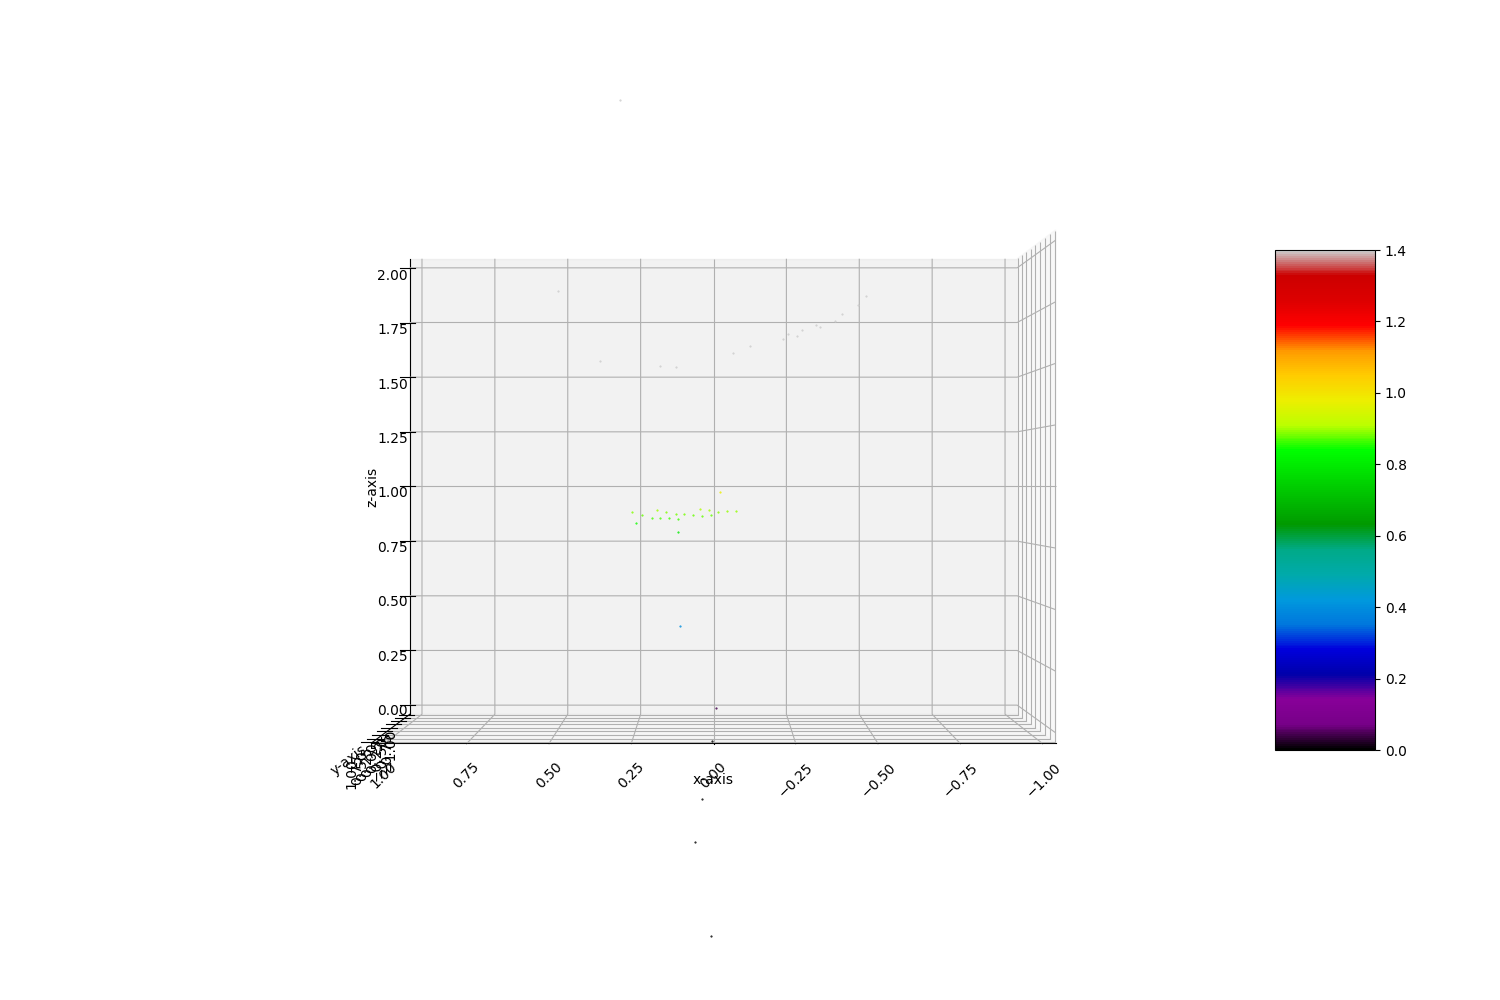

In [ ]:
def draw_setup(elev,azi):
    fig = plt.figure(figsize=(15,10))
    # ax = plt.axes(projection = '3d')
    ax = Axes3D(fig)
    ax.set_xlim([-1,1]) #-0.08,0.005    
    ax.set_ylim([-1,1]) #-0.02,0.02    
    ax.set_zlim([0,2])
    for i in range(0,vis.shape[0],10000):
        # projector points       
        depth_points = ax.scatter(vis[i,0],vis[i,1],vis[i,2], marker = '.',  c = vis[i,2], s = 1, vmin=0,vmax=1.4, cmap=cmap)
        ax.set_xlabel('x-axis')
        ax.set_ylabel('y-axis')
        ax.set_zlabel('z-axis')
        plt.xticks(rotation=45)
        plt.yticks(rotation =90)
        ax.view_init(elev, azi)
    plt.colorbar(depth_points,ax = ax, shrink = 0.5, aspect = 5)
    plt.show()
draw_setup(0, 90)

# draw_setup(0,45)
# draw_setup(45,45)